<a href="https://colab.research.google.com/github/guiuchoa/churn_chances/blob/main/Chances_de_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


**--- Passo 1: Carregar e Limpar os Dados ---**

Carregando planilha

In [2]:
try:
    df = pd.read_csv('base_churn.csv', delimiter=',')
except FileNotFoundError:
    print("Erro: Arquivo 'base_churn.csv' não encontrado. Renomeie seu arquivo ou ajuste o caminho.")
    exit()

print(f"Dados carregados. Shape inicial: {df.shape}")

# Filtro dos status relevantes, conforme sua definição
status_cancelou = ['Sim']
status_nao_cancelou = ['Não']
status_relevantes = status_cancelou + status_nao_cancelou

df_filtrado = df[df['Cancelou'].isin(status_relevantes)].copy()

Dados carregados. Shape inicial: (2000, 12)


**--- Passo 2: Criação da Variável Alvo (Target) ---**

In [3]:
# Criamos a coluna 'Cancelamento', onde 1 = Cancelou e 0 = Não cancelou
df_filtrado['Cancelamento'] = np.where(df_filtrado['Cancelou'].isin(status_cancelou), 1, 0)

print(f"Dados filtrados. Shape após filtro: {df_filtrado.shape}")
print(f"Distribuição da variável alvo:\n{df_filtrado['Cancelamento'].value_counts(normalize=True)}")

Dados filtrados. Shape após filtro: (2000, 13)
Distribuição da variável alvo:
Cancelamento
0    0.647
1    0.353
Name: proportion, dtype: float64


**--- Passo 3: Engenharia de Atributos (Feature Engineering) ---**

In [4]:
# Converter colunas de data para datetime
df_filtrado['Data_Ultimo_Login'] = pd.to_datetime(df_filtrado['Data_Ultimo_Login'])
df_filtrado['Data_Inicio_Contrato'] = pd.to_datetime(df_filtrado['Data_Inicio_Contrato'])

# No cenário de Churn, a métrica de tempo é o 'Tenure' (tempo de relacionamento).
# Clientes muito novos ou muito antigos podem ter comportamentos de cancelamento diferentes.

df_filtrado['tempo_de_contrato_dias'] = (df_filtrado['Data_Ultimo_Login'] - df_filtrado['Data_Inicio_Contrato']).dt.days

# Outra feature temporal útil: Mês do último login (para pegar sazonalidade de cancelamentos)
df_filtrado['mes_referencia'] = df_filtrado['Data_Ultimo_Login'].dt.month

# Feature de 'Recência' (dias desde o último login até uma data de corte)
# Como é uma base estática, vamos assumir que a data de corte é o dia máximo da base.
data_corte = df_filtrado['Data_Ultimo_Login'].max()
df_filtrado['dias_inativo'] = (data_corte - df_filtrado['Data_Ultimo_Login']).dt.days

**--- Passo 4: Definição de Features, Divisão e Pipeline de Pré-processamento ---**


In [5]:
# Seleção de Features baseada nas colunas da base

features_categoricas = [
    'Tipo_Plano',
    'Canal_Venda',
    'Forma_Pagamento',
    'Regiao_Cliente'
]

# Features numéricas:
# Adicionado 'Suporte_Acionado' (forte preditor de insatisfação)
features_numericas = [
    'tempo_de_contrato_dias',
    'dias_inativo',
    'Suporte_Acionado'
]

# Definir X e y
X = df_filtrado[features_categoricas + features_numericas]
y = df_filtrado['Cancelamento']

# Divisão em treino e teste (mantendo a estratificação)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Criação do Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ],
    remainder='passthrough'
)

print(f"Features selecionadas: {X.columns.tolist()}")

Features selecionadas: ['Tipo_Plano', 'Canal_Venda', 'Forma_Pagamento', 'Regiao_Cliente', 'tempo_de_contrato_dias', 'dias_inativo', 'Suporte_Acionado']


**--- Passo 5: Treinamento do Modelo ---**

In [6]:
# Usaremos LogisticRegressionCV, que já faz a validação cruzada para achar o melhor parâmetro de regularização
# penalty='l1' -> Regularização Lasso
# solver='liblinear' -> Bom para Lasso
# cv=5 -> 5-fold cross-validation
# scoring='roc_auc' -> Métrica para otimizar o hiperparâmetro
modelo_cv = LogisticRegressionCV(
    Cs=10, # Número de valores de regularização a testar
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='roc_auc',
    random_state=42,
    max_iter=1000
)

# Criar o pipeline final que junta pré-processamento e modelo
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', modelo_cv)])

# Treinar o pipeline completo
print("\nIniciando o treinamento do modelo...")
pipeline.fit(X_train, y_train)
print("Treinamento concluído.")


Iniciando o treinamento do modelo...
Treinamento concluído.


**--- Passo 6: Avaliação e Interpretação ---**

In [7]:
print("\n--- Avaliação do Modelo no Conjunto de Teste ---")
# Fazer predições no conjunto de teste
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probabilidade de cancelar

# Métricas de avaliação
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Não Cancelou', 'Cancelou']))


# --- Interpretação dos Coeficientes ---
print("\n--- Interpretação dos Coeficientes (Odds Ratio) ---")

# Extrair os nomes das features após o OneHotEncoding
cat_features_out = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(features_categoricas)
all_features = np.concatenate([features_numericas, cat_features_out])

# Extrair os coeficientes do modelo treinado
coefs = pipeline.named_steps['model'].coef_[0]

# Criar um DataFrame para facilitar a visualização
df_coefs = pd.DataFrame({
    'feature': all_features,
    'coef': coefs,
    'odds_ratio': np.exp(coefs)
}).sort_values('odds_ratio', ascending=False)

print("Principais fatores que aumentam a chance de Cancelamento:")
print(df_coefs.head(10))

print("\nPrincipais fatores que diminuem a chance de Cancelamento (aumentam chance de permanecer):")
print(df_coefs.tail(10).sort_values('odds_ratio', ascending=True))



--- Avaliação do Modelo no Conjunto de Teste ---
Acurácia: 0.6925
AUC-ROC: 0.6835

Matriz de Confusão:
[[227  32]
 [ 91  50]]

Relatório de Classificação:
              precision    recall  f1-score   support

Não Cancelou       0.71      0.88      0.79       259
    Cancelou       0.61      0.35      0.45       141

    accuracy                           0.69       400
   macro avg       0.66      0.62      0.62       400
weighted avg       0.68      0.69      0.67       400


--- Interpretação dos Coeficientes (Odds Ratio) ---
Principais fatores que aumentam a chance de Cancelamento:
                            feature      coef  odds_ratio
2                  Suporte_Acionado  0.684900    1.983573
13  Forma_Pagamento_Boleto Bancário  0.625156    1.868537
8            Canal_Venda_App Mobile  0.030805    1.031285
6                 Tipo_Plano_Padrão  0.029684    1.030129
18          Regiao_Cliente_Curitiba  0.026834    1.027197
0            tempo_de_contrato_dias  0.026511    1.026865


/tmp/ipython-input-1131760694.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y='feature', data=top_features, palette=colors, ax=ax3)


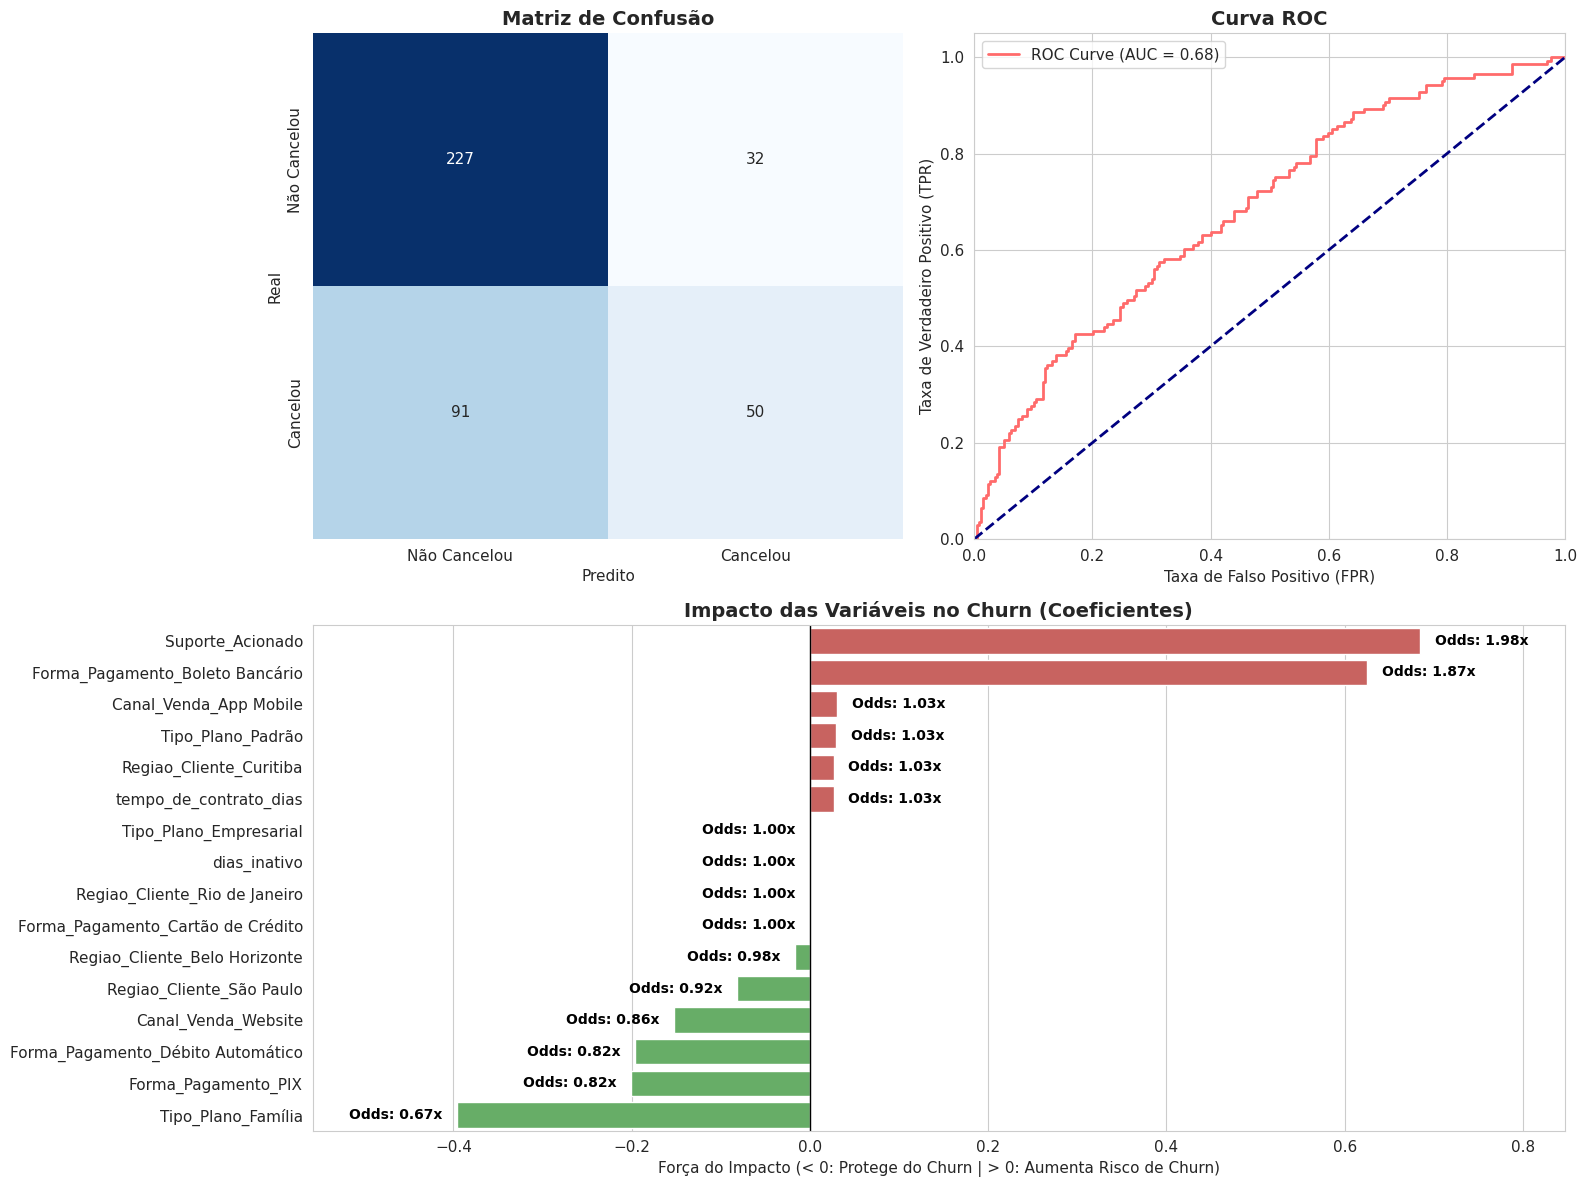

Acurácia Global: 69.25%


In [10]:
# --- Configurações Estéticas ---
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11})

# --- 1. Recalcular Predições e Extrair Coeficientes ---
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Extração de coeficientes
cat_features_out = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(features_categoricas)
all_features = np.concatenate([features_numericas, cat_features_out])
coefs = pipeline.named_steps['model'].coef_[0]

df_coefs = pd.DataFrame({
    'feature': all_features,
    'coef': coefs,
    'odds_ratio': np.exp(coefs)
}).sort_values('coef', ascending=False)

# --- 2. Criação dos Gráficos ---

# Criar uma figura com 2 linhas e 2 colunas
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2)

# --- Gráfico A: Matriz de Confusão ---
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1,
            xticklabels=['Não Cancelou', 'Cancelou'],
            yticklabels=['Não Cancelou', 'Cancelou'])
ax1.set_title('Matriz de Confusão', fontsize=14, fontweight='bold')
ax1.set_ylabel('Real')
ax1.set_xlabel('Predito')

# --- Gráfico B: Curva ROC ---
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

ax2.plot(fpr, tpr, color='#ff6b6b', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Taxa de Falso Positivo (FPR)')
ax2.set_ylabel('Taxa de Verdadeiro Positivo (TPR)')
ax2.set_title('Curva ROC', fontsize=14, fontweight='bold')
# CORREÇÃO 1: 'best' escolhe o melhor lugar para não sobrepor a linha
ax2.legend(loc="best")

# --- Gráfico C: Importância das Features (Top Impactos) ---
top_features = pd.concat([df_coefs.head(8), df_coefs.tail(8)])

ax3 = fig.add_subplot(gs[1, :])
colors = ['#d9534f' if x > 0 else '#5cb85c' for x in top_features['coef']]

sns.barplot(x='coef', y='feature', data=top_features, palette=colors, ax=ax3)

ax3.set_title('Impacto das Variáveis no Churn (Coeficientes)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Força do Impacto (< 0: Protege do Churn | > 0: Aumenta Risco de Churn)')
ax3.set_ylabel('')
ax3.axvline(0, color='black', linewidth=1)

# CORREÇÃO 2: Aumentar limites do eixo X para caber o texto
max_val = top_features['coef'].max()
min_val = top_features['coef'].min()
margin = (max_val - min_val) * 0.15 # 15% de margem extra
ax3.set_xlim(min_val - margin, max_val + margin)

# Adicionar anotações de Odds Ratio
for index, (value, odds) in enumerate(zip(top_features['coef'], top_features['odds_ratio'])):
    label = f"Odds: {odds:.2f}x"
    # Ajuste fino da posição do texto
    if value > 0:
        ax3.text(value + (margin * 0.1), index, label, va='center', color='black', fontsize=10, fontweight='bold')
    else:
        ax3.text(value - (margin * 0.1), index, label, va='center', ha='right', color='black', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Acurácia Global: {accuracy_score(y_test, y_pred):.2%}")